**Install Dependencies**

In [ ]:
!pip install scikit-video

**Imports**

In [ ]:
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import shutil
import math
from scipy.spatial import Delaunay
import skvideo.io
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

**Copy required directories to work-space**

In [ ]:
!cp -r '/content/gdrive/Shareddrives/CIS 581- Face Swapping In Videos/project/model' /content
!cp -r '/content/gdrive/Shareddrives/CIS 581- Face Swapping In Videos/project/videos/src' /content
!cp -r '/content/gdrive/Shareddrives/CIS 581- Face Swapping In Videos/project/faceBlendCommon.py' /content

In [ ]:
MODEL_PATH = '/content/gdrive/Shareddrives/CIS 581- Face Swapping In Videos/project/model/'
PREDICTOR_PATH = MODEL_PATH + "shape_predictor_68_face_landmarks.dat"
RESIZE_HEIGHT = 480
NUM_FRAMES_FOR_FPS = 100
SKIP_FRAMES = 1
detector = dlib.get_frontal_face_detector()
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

# Stabilizing the video
This function returns points of the detected face, after being stabilized. Takes in one frame at a time as an argument


In [ ]:
def interEyeDistance(predict):
  leftEyeLeftCorner = (predict[36].x, predict[36].y)
  rightEyeRightCorner = (predict[45].x, predict[45].y)
  distance = cv2.norm(np.array(rightEyeRightCorner) - np.array(leftEyeLeftCorner))
  distance = int(distance)
  return distance

In [ ]:
def stabilise(im):
  '''CHANGED TO RETURN LIST OF POINTS (FOR ALL FACES DETECTED)'''
  points=[]
  pointsPrev=[]
  pointsDetectedCur=[]
  pointsDetectedPrev=[]
  all_stabilized_frames=[]

  eyeDistanceNotCalculated = True
  eyeDistance = 0
  isFirstFrame = True
  fps = 10
  showStabilized = False
  count =0

  imDlib = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  imGray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) # improve image contrast
  imGray= clahe.apply(imGray)
  imGrayPrev = imGray

  height = im.shape[0]

  IMAGE_RESIZE = float(height)/RESIZE_HEIGHT
  imSmall = cv2.resize(im, None, fx=1.0/IMAGE_RESIZE, fy=1.0/IMAGE_RESIZE,interpolation = cv2.INTER_LINEAR)
  imSmallDlib = cv2.cvtColor(imSmall, cv2.COLOR_BGR2RGB)
    # if (count % SKIP_FRAMES == 0):
  faces = detector(imSmallDlib, 1)
  if len(faces)==0:
    # print("No face detected")
    pass
  else:
    # print(f"No. of faces detected: {len(faces)}")
    points = []
    for i in range(0,len(faces)):
        # print("face detected")
        newRect = dlib.rectangle(int(faces[i].left() * IMAGE_RESIZE),
          int(faces[i].top() * IMAGE_RESIZE),
          int(faces[i].right() * IMAGE_RESIZE),
          int(faces[i].bottom() * IMAGE_RESIZE))
        landmarks = landmarkDetector(imDlib, newRect).parts()
        # print(f"length of landmarks: {len(landmarks)}")
        points_new = []
        if (isFirstFrame==True):
          pointsPrev=[]
          pointsDetectedPrev = []
          [pointsPrev.append((p.x, p.y)) for p in landmarks]
          [pointsDetectedPrev.append((p.x, p.y)) for p in landmarks]
        else:
          pointsPrev=[]
          pointsDetectedPrev = []
          pointsPrev = points_new
          pointsDetectedPrev = pointsDetectedCur
        
        pointsDetectedCur = []
        [points_new.append((p.x, p.y)) for p in landmarks]
        [pointsDetectedCur.append((p.x, p.y)) for p in landmarks]
        pointsArr = np.array(points_new,np.float32)
        pointsPrevArr = np.array(pointsPrev,np.float32)
        if eyeDistanceNotCalculated:
          eyeDistance = interEyeDistance(landmarks)
        #   print(eyeDistance)
          eyeDistanceNotCalculated = False
        if eyeDistance > 100:
            dotRadius = 3
        else:
          dotRadius = 2
        sigma = eyeDistance * eyeDistance / 400
        s = 2*int(eyeDistance/4)+1
        lk_params = dict(winSize  = (s, s), maxLevel = 5, criteria = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 20, 0.03))
        pointsArr,status, err = cv2.calcOpticalFlowPyrLK(imGrayPrev,imGray,pointsPrevArr,pointsArr,**lk_params)
        pointsArrFloat = np.array(pointsArr,np.float32)
        points_new = pointsArrFloat.tolist()
        for k in range(0,len(landmarks)):
          d = cv2.norm(np.array(pointsDetectedPrev[k]) - np.array(pointsDetectedCur[k]))
          alpha = math.exp(-d*d/sigma)
          points_new[k] = (1 - alpha) * np.array(pointsDetectedCur[k]) + alpha * np.array(points_new[k])
        points.append(points_new)
    return points

# Convex Hull

Find the convex hull of both faces to know the exact region to swap


In [ ]:
def convex_hull(points, points1):
  '''No Change'''
  vec = np.empty([68,2], dtype=int)
  for b in range(68):
    vec[b][0] = points[b][0]
    vec[b][1] = points[b][1]

  indices = cv2.convexHull(np.array(vec), returnPoints = False)
  hull1 = vec[indices[:,0]]
  vec1 = np.empty([68,2], dtype=int)
  for b in range(68):
    vec1[b][0] = points1[b][0]
    vec1[b][1] = points1[b][1]
  hull2 = vec1[indices[:,0]]
  return hull1, hull2

# Triangulation


In [ ]:
# Warps and alpha blends triangular regions from img1 and img2
def warpTriangle(img1, img2, tri1, tri2):
  # Find bounding rectangle for each triangle
    rect1 = cv2.boundingRect(np.float32([tri1]))
    rect2 = cv2.boundingRect(np.float32([tri2]))

    # Offset points by left top corner of the respective rectangles
    tri1Rect = np.zeros((3,2))
    tri2Rect = np.zeros((3,2))

    #iterate over the three points
    for i in range(0, 3):
        tri1Rect[i] = ((tri1[i][0] - rect1[0]), (tri1[i][1] - rect1[1]))
        tri2Rect[i] = (((tri2[i][0] - rect2[0]), (tri2[i][1] - rect2[1])))

    # Get mask
    mask = np.zeros((rect2[3], rect2[2], 3), dtype=np.float32)
    cv2.fillConvexPoly(mask, np.int32(tri2Rect), (1.0, 1.0, 1.0), 16, 0)

    mask2 = np.zeros((rect1[3], rect1[2], 3), dtype=np.float32)
    cv2.fillConvexPoly(mask2, np.int32(tri1Rect), (1.0, 1.0, 1.0), 16, 0)

    # Apply warpImage to rectangles
    img1Rect = img1[rect1[1]:rect1[1] + rect1[3], rect1[0]:rect1[0] + rect1[2]]
    img2RectNew = img2[rect2[1]:rect2[1] + rect2[3], rect2[0]:rect2[0] + rect2[2]]

    # get the size of the rectangle
    size = (rect2[2], rect2[3])
    size2 = (rect1[2], rect1[3])

    #do the affine transformation
    affineWarped = cv2.getAffineTransform(np.float32(tri1Rect), np.float32(tri2Rect))
    img2Rect = cv2.warpAffine(img1Rect, affineWarped, (size[0], size[1]), None, flags=cv2.INTER_LINEAR,borderMode=cv2.BORDER_REFLECT_101)

    affineWarpedNew = cv2.getAffineTransform(np.float32(tri2Rect), np.float32(tri1Rect))
    img1RectNew = cv2.warpAffine(img2RectNew, affineWarpedNew, (size2[0], size2[1]), None, flags=cv2.INTER_LINEAR,borderMode=cv2.BORDER_REFLECT_101)

    #apply mask to img2rectangle
    img2Rect = img2Rect * mask
    img1RectNew = img1RectNew * mask2

    # Copy triangular region of the rectangular patch to the output image
    img2[rect2[1]:rect2[1] + rect2[3], rect2[0]:rect2[0] + rect2[2]] = img2[rect2[1]:rect2[1] + rect2[3], rect2[0]:rect2[0] + rect2[2]] * ((1.0, 1.0, 1.0) - mask)
    img2[rect2[1]:rect2[1] + rect2[3], rect2[0]:rect2[0] + rect2[2]] = img2[rect2[1]:rect2[1] + rect2[3], rect2[0]:rect2[0] + rect2[2]] + img2Rect

    img2[rect1[1]:rect1[1] + rect1[3], rect1[0]:rect1[0] + rect1[2]] = img2[rect1[1]:rect1[1] + rect1[3], rect1[0]:rect1[0] + rect1[2]] * ((1.0, 1.0, 1.0) - mask2)
    img2[rect1[1]:rect1[1] + rect1[3], rect1[0]:rect1[0] + rect1[2]] = img2[rect1[1]:rect1[1] + rect1[3], rect1[0]:rect1[0] + rect1[2]] + img1RectNew

In [ ]:
def triangulation(hull1, hull2, img1, img2):
  '''Need to change the final part - TODO'''
  img2 = np.copy(img2)
  img2_copy = np.copy(img2)

  #create delanuy triangulation
  tri = Delaunay(hull2).simplices
  
  numTriangles = len(tri)
  for i in range(0, numTriangles):
    triangle = tri[i]
    pts1 = np.zeros((3, 2), dtype=np.float32)
    pts2 = np.zeros((3, 2), dtype=np.float32)

    # calculate transform for each triangle in both directions
    pts1[0] = hull1[triangle[0]]
    pts1[1] = hull1[triangle[1]]
    pts1[2] = hull1[triangle[2]]

    pts2[0] = hull2[triangle[0]]
    pts2[1] = hull2[triangle[1]]
    pts2[2] = hull2[triangle[2]]

    warpTriangle(img1, img2, pts1, pts2) # this will repclace both the masks
  
  # get the mask of only the hull for blending
  img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
  face_mask = np.zeros_like(img2_gray)
  head_mask = cv2.fillConvexPoly(face_mask, np.int32(hull2), 255)
  face_mask = cv2.bitwise_not(head_mask)

  face_mask2 = np.zeros_like(img2_gray)
  head_mask2 = cv2.fillConvexPoly(face_mask2, np.int32(hull1), 255)
  face_mask2 = cv2.bitwise_not(head_mask2)

  head_no_face = cv2.bitwise_and(img2, img2, mask=face_mask)
  result = cv2.add(head_no_face, img2)

  head_no_face2 = cv2.bitwise_and(img2, img2, mask=face_mask2)
  result2 = cv2.add(head_no_face2, img2)

#   cv2_imshow(result)
#   cv2_imshow(result2)

  r = cv2.boundingRect(np.float32([hull2]))
  faceCenter = (r[0]+int(r[2]/2), r[1]+int(r[3]/2))
  
  r2 = cv2.boundingRect(np.float32([hull1]))
  faceCenter2 = (r2[0]+int(r2[2]/2), r2[1]+int(r2[3]/2))

  #do the blending
  ## TODO: blend here or in warp
  finalImage = cv2.seamlessClone(np.uint8(result), np.uint8(img2), head_mask, faceCenter, cv2.MIXED_CLONE)
  # cv2_imshow(finalImage)
  finalImage2 = cv2.seamlessClone(np.uint8(result2), np.uint8(img2), head_mask2, faceCenter2, cv2.NORMAL_CLONE)

  #conert the image to a RGB image from BGR image that cv2 returns
  return cv2.cvtColor(np.uint8(finalImage), cv2.COLOR_BGR2RGB)

# Main code to run face swapping
Takes in video_path as an arguments, stores results in a local variable called ''swapped_video''.

In [ ]:
def same_video_face_swapping(video_path):
  cap = cv2.VideoCapture(video_path)
  frames = []
  
  pic, frame = cap.read()
  pic = True
  while(pic):
      pic, frame = cap.read()
      if pic==True:
          frames.append(frame)
      else:
          break
  cap.release()
  [h1, w1, _] = frames[0].shape
  swapped_video = np.zeros((len(frames) - 1, h1, w1, 3), dtype=np.uint8)
  count = 0
  for i in range(len(frames) - 1):
      img = np.copy(frames[i])
      points = stabilise(img)
      if points is None:
        print("NONE")
        continue
      if np.array(points).shape[0] != 2:
        print("Invalid number of faces for single video")
        continue
      hull1, hull2 = convex_hull(points[0], points[1])
      temp = triangulation(hull1, hull2, img, img) 
      gray = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
      cv2_imshow(gray) # debugging
      ret, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
      cv2_imshow(thresh) # debugging
      swapped_video[i,:,:,:] = temp
      # if i==2: # for debugging and testing
      #   break
  return swapped_video

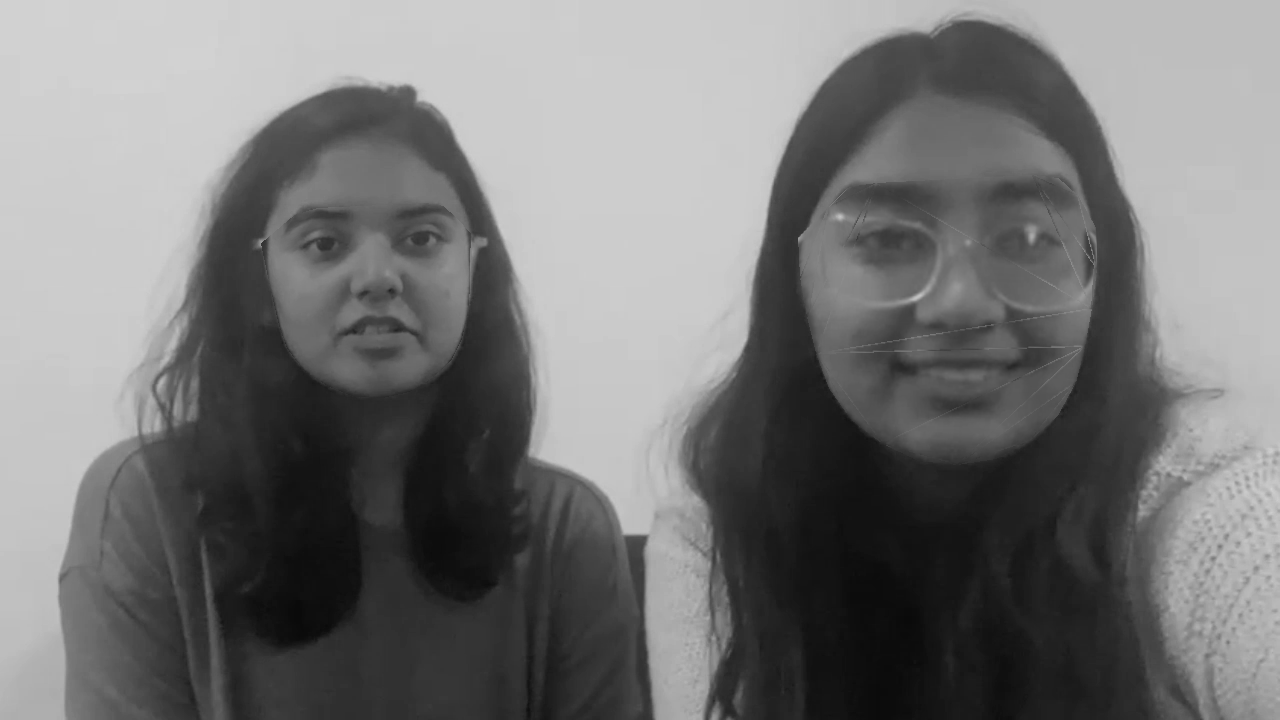

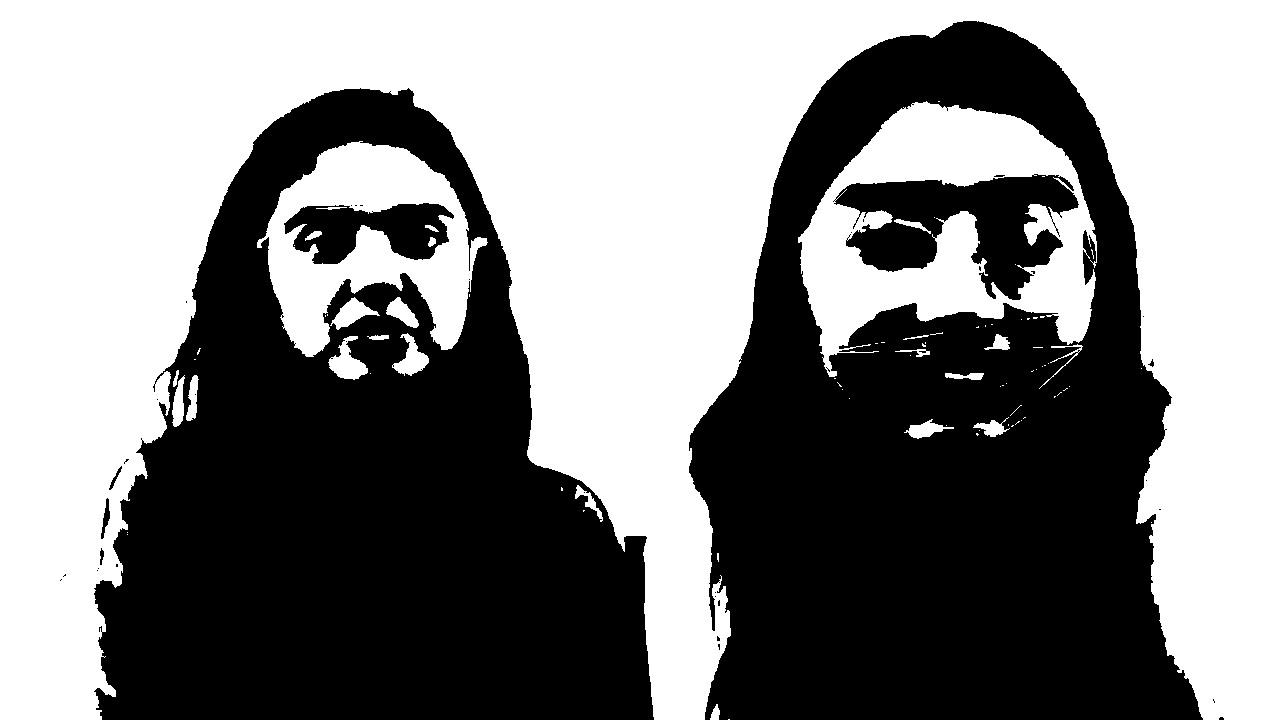

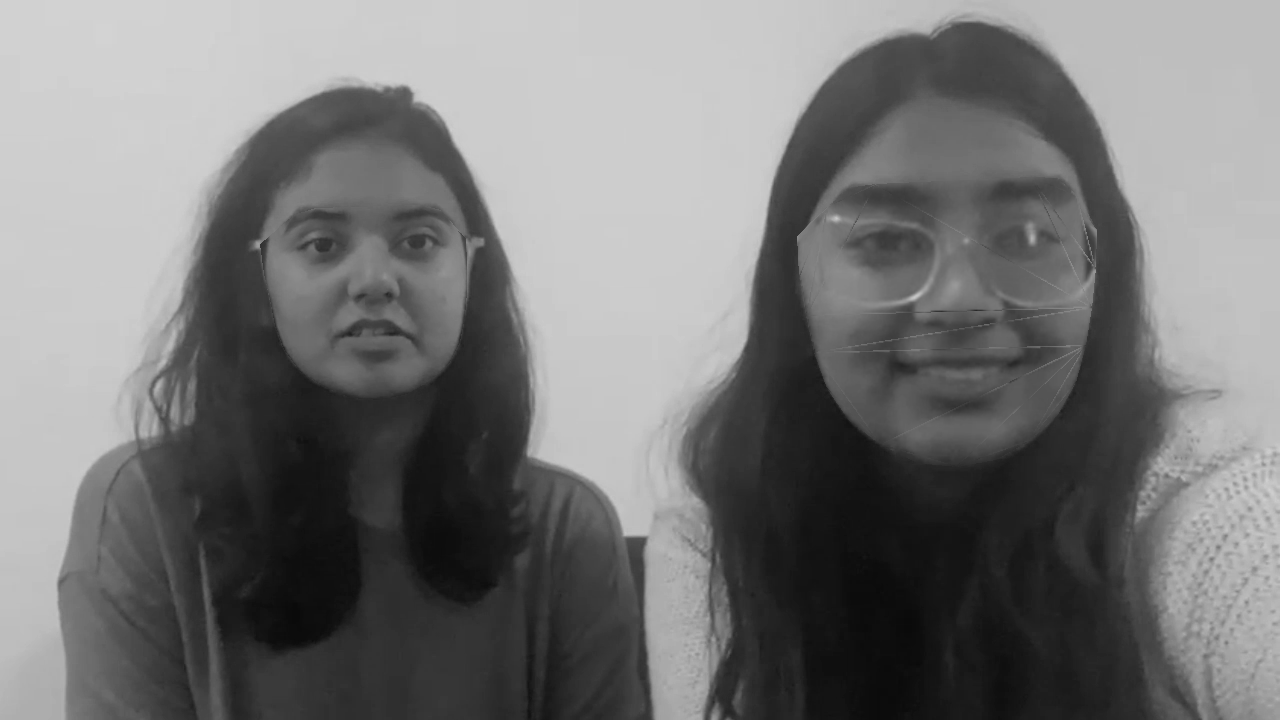

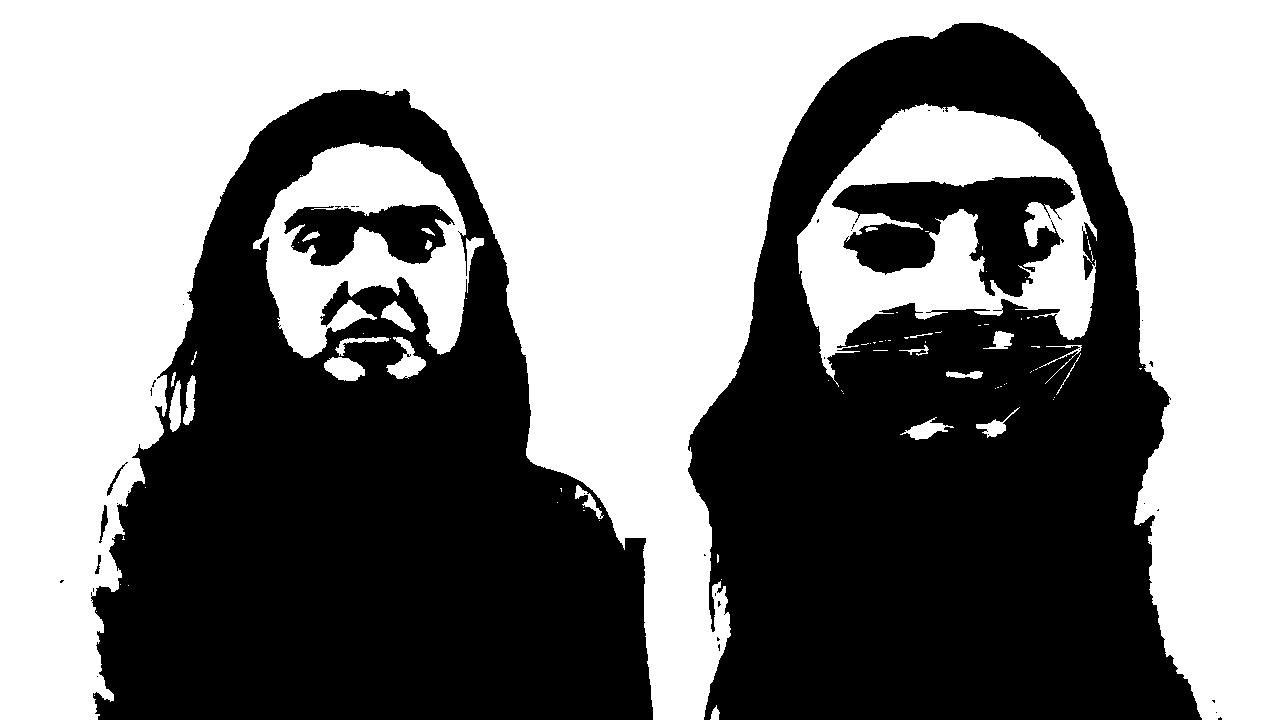

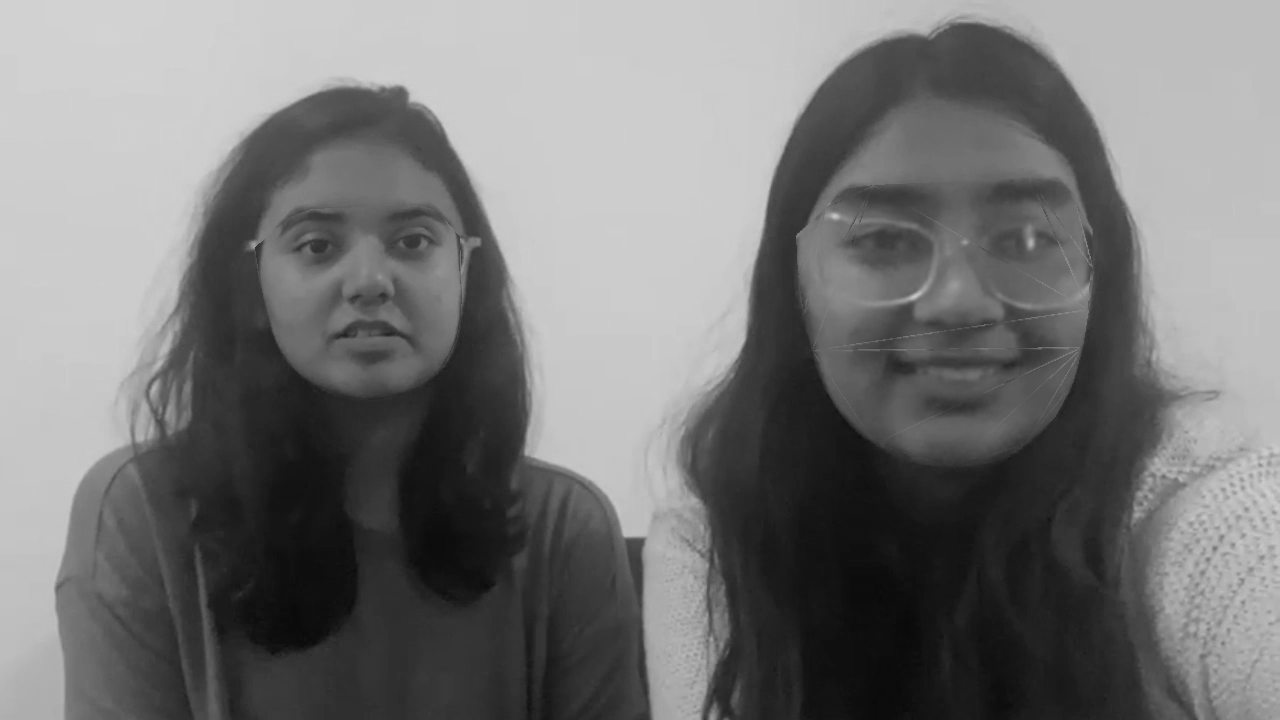

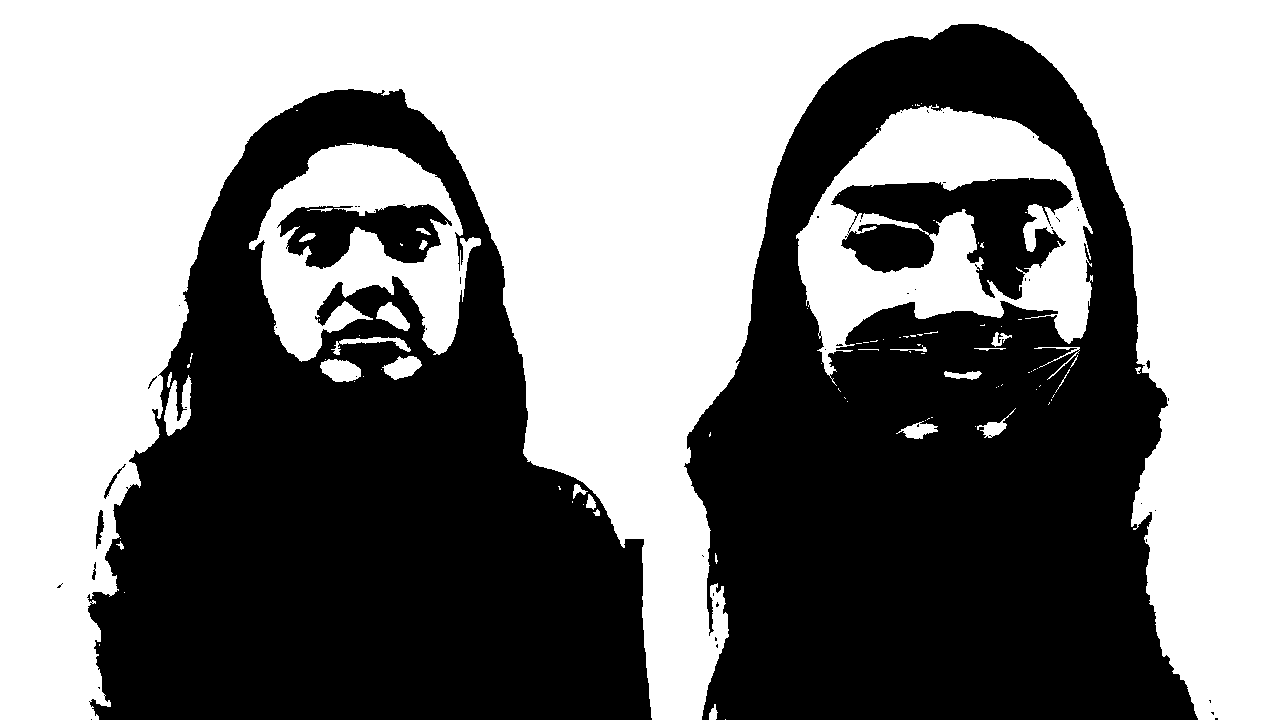

In [ ]:
video_path = '/content/gdrive/Shareddrives/CIS 581- Face Swapping In Videos/dataset/same_video/test.mp4' # test.mp4, test2.mp4, test3.mp4
swapped_video = same_video_face_swapping(video_path)

In [ ]:
# uncomment this only the first time you are saving a video
# count = 0

# Saves local variable as video file to local workspace 
(don't forget to download it from the runtime, because if the runtime is refreshed the video will be deleted)

In [ ]:
skvideo.io.vwrite(f"/content/gdrive/Shareddrives/CIS 581- Face Swapping In Videos/outputs/same_video_face_swap{count}.mp4", swapped_video)
count += 1